In [9]:
from tqdm import tqdm
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
wandb.login(relogin=True)
api = wandb.Api()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/kutsev/.netrc


In [15]:
# project_names = ["Composable_Interventions", "AK_Tests"]
project_names = ["dri-ice/Composable_Interventions"]
all_runs_frame = None
for project_name in project_names:
    runs = api.runs(project_name)
    for run in tqdm(runs, desc=f"Loading runs for project: {project_name}"):
        if run.state != "finished":
            continue

        skip_tags = ["test", "hparam_search", "none"]
        should_skip = False
        for tag in skip_tags:
            if tag in run.config["tag"].lower():
                should_skip = True
        
        if should_skip:
            continue

        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-1 12:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            if all_runs_frame is None:
                all_runs_frame = combined_frame
            else:
                all_runs_frame = pd.concat([all_runs_frame, combined_frame])
        except:
            print(f"Failed to load run {run.id}")
            continue

    all_runs_frame = all_runs_frame.sort_values("_timestamp", ascending=False)
    for column in all_runs_frame.columns:
        all_runs_frame[column] = all_runs_frame[column].apply(lambda x: str(x) if isinstance(x, dict) or isinstance(x, list) else x)

all_runs_frame

Loading runs for project: dri-ice/Composable_Interventions:  52%|█████▏    | 51/99 [00:00<00:00, 148.22it/s]

Failed to load run n0iel6ok
Failed to load run xr5mede5
Failed to load run 27f8pxs0


Loading runs for project: dri-ice/Composable_Interventions: 100%|██████████| 99/99 [00:00<00:00, 207.12it/s]


,tag,edit,save,seed,v_lr,dtype,wandb,wbits,device,method,...,percdamp,act_order,groupsize,zero_point,use_variant,prune_method,sparsity_type,static_groups,true_sequential,quant_method
0,sparsegpt0.65\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,sparsegpt0.45\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,sparsegpt0.25\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,memit-rmu,memit,out/,42,0.5,torch.bfloat16,online,16,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,rmu-sparsegpt0.45\%,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Compress_AWQ2bit,none,out/,0,NaN,torch.float16,online,2,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ8bit,none,out/,0,NaN,torch.float16,online,8,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ4bit,none,out/,0,NaN,torch.float16,online,4,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ2bit,none,out/,0,NaN,torch.float16,online,2,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq


In [16]:
# Drop duplicate experiments, keep the most recent
all_runs_frame = all_runs_frame.drop_duplicates(subset=[col for col in all_runs_frame.columns if col not in ["tag", "Metrics"] and not col.startswith("_")])
all_runs_frame

,tag,edit,save,seed,v_lr,dtype,wandb,wbits,device,method,...,percdamp,act_order,groupsize,zero_point,use_variant,prune_method,sparsity_type,static_groups,true_sequential,quant_method
0,sparsegpt0.65\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,sparsegpt0.45\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,sparsegpt0.25\%-rmu,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
0,memit-rmu,memit,out/,42,0.5,torch.bfloat16,online,16,0,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,rmu-sparsegpt0.45\%,none,out/,0,NaN,torch.bfloat16,online,4,0,prune,...,0.01,False,128.0,True,False,sparsegpt,unstructured,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Compress_AWQ2bit,none,out/,0,NaN,torch.float16,online,2,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ8bit,none,out/,0,NaN,torch.float16,online,8,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ4bit,none,out/,0,NaN,torch.float16,online,4,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq
0,Compress_AWQ2bit,none,out/,0,NaN,torch.float16,online,2,0,quant,...,0.01,False,128.0,True,False,NaN,NaN,False,False,autoawq


In [4]:
# ["lr", "tag", "edit", "rank", "save", "seed", "dtype", "wandb", "device", "method", "rmu_lr", "dataset", "unlearn", "alg_name", "compress", "edit_set", "rmu_seed", "ckpt_path", "kl_factor", "load_ckpt", "lora_type", "num_steps", "rmu_alpha", "save_ckpt", "stats_dir", "batch_size", "lora_alpha", "max_length", "model_name", "save_model", "compression", "rmu_max_len", "rmu_min_len", "edit_dataset", "lora_dropout", "rmu_layer_id", "weight_decay", "interventions", "rmu_layer_ids", "rmu_param_ids", "eval_zero_shot", "model_parallel", "rmu_batch_size", "sparsity_ratio", "target_modules", "unlearn_method", "norm_constraint", "number_of_edits", "rmu_forget_corpora", "rmu_retain_corpora", "compression_dataset", "rmu_max_num_batches", "rmu_steering_coeffs", "PPL edits", "wmdp_cyber", "wmdp_bio accuracy", "mmlu stderr", "Local recall", "wmdp_cyber accuracy", "Success recall", "FLOPs", "Locality", "wmdp_bio", "mmlu accuracy", "PPl edits unmasked", "Generalization recall", "Metrics", "_step", "Average bits", "mmlu", "_wandb", "_runtime", "Rewrite accuracy", "PPL", "Latency", "PPl QA", "Generalization", "wmdp_bio stderr", "wmdp_cyber stderr", "_timestamp", "ln_f_module", "lm_head_module", "mlp_module_tmp", "attn_module_tmp", "layer_module_tmp", "rewrite_module_tmp", "objective_optimization", "sym", "wbits", "nearest", "new_eval", "nsamples", "percdamp", "act_order", "groupsize", "zero_point", "use_variant", "prune_method", "sparsity_type", "static_groups", "true_sequential"]

In [5]:
all_runs_frame["interventions"].value_counts()

interventions
['unlearn', 'compress']    6
['compress']               6
['compress', 'unlearn']    4
['edit', 'unlearn']        3
['edit', 'compress']       3
['unlearn', 'edit']        2
['edit']                   1
Name: count, dtype: int64

In [6]:
# ['compress', 'unlearn']
# get all cases where compress then unlearn
all_runs_frame[(all_runs_frame["interventions"] == "['compress', 'unlearn']") & (all_runs_frame["compression"] == "wanda")]

,lr,tag,edit,save,seed,dtype,wandb,wbits,device,method,...,true_sequential,prune_method,sparsity_type,rank,wbit,kl_factor,lora_type,lora_alpha,lora_dropout,target_modules
0,NaN,wanda0.65\%-rmu,none,out/,0,torch.bfloat16,online,4.0,0,prune,...,False,wanda,unstructured,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_40097/643714344.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wanda_then_rmu_frame["plot_tag"] = "Wanda->RMU"
/tmp/ipykernel_40097/643714344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wanda_then_rmu_frame["plot_tag"] = "Wanda->RMU"


,lr,tag,edit,save,seed,dtype,wandb,wbits,device,method,...,prune_method,sparsity_type,rank,wbit,kl_factor,lora_type,lora_alpha,lora_dropout,target_modules,plot_tag
0,NaN,wanda0.65\%-rmu,none,out/,0,torch.bfloat16,online,4.0,0,prune,...,wanda,unstructured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wanda->RMU


/tmp/ipykernel_40097/643714344.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rmu_then_wanda_frame["plot_tag"] = "RMU->Wanda"
/tmp/ipykernel_40097/643714344.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmu_then_wanda_frame["plot_tag"] = "RMU->Wanda"


,lr,tag,edit,save,seed,dtype,wandb,wbits,device,method,...,prune_method,sparsity_type,rank,wbit,kl_factor,lora_type,lora_alpha,lora_dropout,target_modules,plot_tag
0,NaN,rmu-wanda0.65\%,none,out/,0,torch.bfloat16,online,4.0,0,prune,...,wanda,unstructured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RMU->Wanda


<Axes: xlabel='sparsity_ratio', ylabel='mmlu accuracy'>

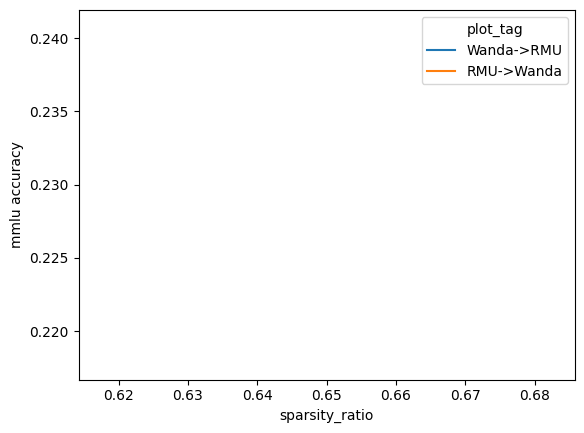

In [7]:
wanda_then_rmu_frame = all_runs_frame[(all_runs_frame["interventions"] == "['compress', 'unlearn']") & (all_runs_frame["compression"] == "wanda")]
wanda_then_rmu_frame["plot_tag"] = "Wanda->RMU"
display(wanda_then_rmu_frame)

rmu_then_wanda_frame = all_runs_frame[(all_runs_frame["interventions"] == "['unlearn', 'compress']") & (all_runs_frame["compression"] == "wanda")]
rmu_then_wanda_frame["plot_tag"] = "RMU->Wanda"
display(rmu_then_wanda_frame)

combined_plot_frame = pd.concat([wanda_then_rmu_frame, rmu_then_wanda_frame])

# create a line plot of the two where the x axis is sparsity and the y axis is accuracy
fig, ax = plt.subplots()
sns.lineplot(data=combined_plot_frame, x="sparsity_ratio", y="mmlu accuracy", hue="plot_tag", ax=ax)

